# CareMap: EHR Companion

## One Model. Three Modules. Maximum Impact on Both Sides of Healthcare.

---

**Kaggle Solve for India with Gemini Competition**

CareMap demonstrates how a single clinical AI model (MedGemma) can enhance healthcare on **both sides**:

| Side | Who | Module | MedGemma Mode |
|------|-----|--------|---------------|
| **Patient Side** | Caregivers, Ayahs, Families | Fridge Sheet Generator | Text Reasoning |
| **Provider Side** | Radiologists | X-ray Triage Queue | **Multimodal** |
| **Provider Side** | Lab/Clinical Staff | HL7 Message Triage | Text Reasoning |

---

## The Problem: Healthcare Information Overload

### On the Patient Side

Family caregivers receive overwhelming amounts of medical information:
- Dense clinical notes with medical jargon
- Multiple medication instructions with complex interactions
- Lab results with unexplained abbreviations
- Follow-up tasks scattered across documents

**In India specifically**, the challenge is compounded by:
- **Rotating Ayahs** (home health workers) who change frequently
- **Language barriers** - Ayahs often cannot read English
- **No EHR infrastructure** - patients carry paper records in bags
- **Overwhelmed doctors** - seeing 125-175 patients per day

### On the Provider Side

Healthcare workers are drowning in data:
- **Radiologists**: 1:100,000 patient ratio in India, 72-hour report delays
- **Lab Staff**: 1000+ HL7 messages per day, critical values buried in routine results
- **No prioritization** - life-threatening findings wait in queue behind normal studies

---

## User Research: Voices from the Field

We interviewed **4 healthcare professionals and caregivers** to understand the real challenges. Their insights directly shaped how MedGemma powers CareMap.

---

### The Need for Simple, Plain-Language Explanations

**Dr. Vinodhini Sriram** (Primary Care Physician, US)

> "For the caregivers, I think it's mainly the medications. They are not going to care about the kidney function... **All they need is that first page which is the medication 8:00 a.m., 12 p.m., whatever it is.**"

> "Absolutely. If the source of this data is reliable, **this is very good.**"

*How MedGemma helps:* Transforms complex sig codes like "PO BID AC" into plain language: "Take by mouth, twice daily, before meals."

---

### The Family Caregiver's Burden

**Sunayana Mann** (Daughter/Family Caregiver)

> "If I had to drive her to the hospital, she cannot tell me all the medications and I might not be able to grab the whole bag. **So easiest would be... I peel the fridge magnet.**"

> "**Task oriented for them** like I don't want them to think. I want to give them instructions and I want them to follow it like nothing extra."

> "**I'm not a medical professional.** I don't know all these things... I need someone to tell me what questions to ask."

*How MedGemma helps:* Generates "Ask the Doctor" prompts so families know what questions matter for their specific situation.

---

### The Reality of Healthcare in India

**Dr. Manini Moudgal** (Pediatrician, Bangalore, India)

> "Given the volumes that we deal with over here, **EHR is a bloody headache**... We usually see **125-175 patients a day.**"

> "The parents don't understand what I'm writing. They just want to know - **when do I give this medicine, how much, and what should I watch for?**"

*How MedGemma helps:* Extracts the essential "what, when, and watch for" from clinical notes, eliminating jargon.

---

### Two Audiences, Two Levels of Detail

**Dr. Gaurav Mishra** (Psychiatrist, Geriatric Focus)

> "**The pages for the ayah need to be even simpler**... for kids with autism sometimes we would use image based chart."

> "I would have **both levels available**... deep dive for family, simple for ayah."

> "The ayah changes every week. **How do you hand off care?** You can't expect verbal instructions to work."

*How MedGemma helps:* Generates separate pages for Ayahs (visual, task-focused) and Family (context, explanations, connections).

---

### Common Themes → CareMap Design Principles

| User Research Insight | CareMap Response |
|----------------------|------------------|
| "All they need is medication times" | Page 1: Medication Schedule with time/food badges |
| "I need someone to tell me what to ask" | MedGemma generates "Ask the Doctor" prompts |
| "Two levels - deep dive and simple" | Separate pages for Ayah vs Family audiences |
| "Ayah changes every week" | Printable poster reduces reliance on verbal handoffs |
| "Don't omit medications" | All 8 medications shown, nothing hidden |
| "Emergency contacts" | Page 5: Who to call when something goes wrong |

---

## The Hypothesis

**A single clinical AI model can serve BOTH sides of healthcare:**

```
                    ┌─────────────────────────────────┐
                    │         MedGemma 4B-IT          │
                    │   Clinical Foundation Model     │
                    │   (Text + Multimodal)           │
                    └─────────────────────────────────┘
                                   │
              ┌────────────────────┼────────────────────┐
              │                    │                    │
              ▼                    ▼                    ▼
    ┌─────────────────┐  ┌─────────────────┐  ┌─────────────────┐
    │  Module 1       │  │  Module 2       │  │  Module 3       │
    │  Fridge Sheets  │  │  X-ray Triage   │  │  HL7 Triage     │
    │  (Patient Side) │  │  (Multimodal)   │  │  (Provider Side)│
    └─────────────────┘  └─────────────────┘  └─────────────────┘
           │                    │                    │
           ▼                    ▼                    ▼
    Ayahs & Families     Radiologists        Lab Staff
```

**Why MedGemma?**

MedGemma is specifically trained on clinical text including **Electronic Health Records (EHR)**, making it ideal for:
- Understanding medication sig codes (e.g., "PO BID AC" → "by mouth, twice daily, before meals")
- Interpreting lab result patterns and clinical significance
- Analyzing chest X-rays for findings and urgency
- Translating medical jargon while preserving safety-critical information

---

## Environment Setup

In [1]:
# Install dependencies (uncomment if running on Kaggle or fresh environment)
# !pip install -q transformers>=4.39.0 accelerate>=0.27.0 huggingface-hub>=0.34.0 pydantic>=2.6.0 sentencepiece tqdm

In [2]:
import json
import os
import sys
from pathlib import Path
from typing import Dict, Any, List
from IPython.display import display, Markdown, HTML, IFrame
from tqdm import tqdm

# Add src to path for imports
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root / 'src'))

print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")

Project root: /Users/rumpagiri/Projects/caremap-medgemma
Python version: 3.14.2 (main, Dec  5 2025, 16:49:16) [Clang 17.0.0 (clang-1700.4.4.1)]


In [3]:
# Load MedGemma
from caremap.llm_client import MedGemmaClient

print("Loading MedGemma 4B-IT...")
print("(This may take 1-2 minutes on first run)")

client = MedGemmaClient()

print(f"\nModel: {client.model_id}")
print(f"Device: {client.device}")
print("Ready!")

Loading MedGemma 4B-IT...
(This may take 1-2 minutes on first run)


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Model: google/medgemma-4b-it
Device: mps
Ready!


---

## Module 1: Patient Portal - Fridge Sheet Generator

### The Use Case: Dadu's Care Team

**Dadu** is an 82-year-old grandfather with:
- Type 2 Diabetes with kidney complications (CKD Stage 3b)
- Congestive Heart Failure
- Atrial Fibrillation (on blood thinners)

He has **8 medications** with complex interactions, **6 lab results** to monitor, and **5 care actions** to track.

His care team includes:
- **Rotating Ayahs** who may change weekly
- **His daughter** who lives in another city
- **His spouse** who is also elderly

CareMap generates **5 printable pages** tailored to each audience:

| Page | Audience | Purpose |
|------|----------|--------|
| 1. Medications | Ayah/Helper | Daily schedule with time/food badges |
| 2. Labs | Family Caregiver | Test results in plain language |
| 3. Care Actions | Family Caregiver | Today/Week/Later task buckets |
| 4. Imaging | Family Caregiver | X-ray findings explained |
| 5. Connections | Both | How meds, labs, and actions connect |

In [4]:
# Load Dadu's patient data
golden_file = project_root / 'examples' / 'golden_patient_complex.json'

with open(golden_file) as f:
    patient_data = json.load(f)

print(f"Patient: {patient_data['patient']['nickname']}")
print(f"Age: {patient_data['patient']['age_range']}")
print(f"Conditions: {', '.join(patient_data['patient']['conditions_display'])}")
print(f"\nMedications: {len(patient_data['medications'])}")
print(f"Lab Results: {len(patient_data['results'])}")
print(f"Care Gaps: {len(patient_data['care_gaps'])}")

Patient: Dadu
Age: 80s
Conditions: Type 2 Diabetes with kidney complications, Congestive Heart Failure, Atrial Fibrillation

Medications: 8
Lab Results: 6
Care Gaps: 5


### 1.1 Medication Interpretation

MedGemma transforms complex medication instructions into plain language:

**Input (from EHR):**
```
Warfarin - Take as directed based on INR results
Clinician Notes: Target INR 2.0-3.0 for AFib. Weekly INR checks required.
Interaction Notes: Avoid NSAIDs. Keep vitamin K intake consistent.
```

**Output (for Ayah):**
- **What it does:** Helps prevent dangerous blood clots
- **When:** Evening, same time each day
- **Watch for:** Unusual bleeding, bruising

In [5]:
from caremap.medication_interpretation import interpret_medication_v3_grounded

print("Interpreting medications with MedGemma...")
print("=" * 60)

# Interpret first 3 medications as examples
for med in tqdm(patient_data['medications'][:3], desc="Medications"):
    result, _ = interpret_medication_v3_grounded(
        client=client,
        medication_name=med['medication_name'],
        sig_text=med['sig_text'],
        clinician_notes=med.get('clinician_notes', ''),
        interaction_notes=med.get('interaction_notes', ''),
    )
    
    print(f"\n{'='*60}")
    print(f"MEDICATION: {med['medication_name']} ({med['timing']})")
    print(f"{'='*60}")
    if 'raw_response' not in result:
        print(f"What this does: {result.get('what_this_does', 'N/A')}")
        print(f"Watch out for: {result.get('watch_out_for', 'N/A')}")

Interpreting medications with MedGemma...


Medications:  33%|███▎      | 1/3 [00:09<00:18,  9.07s/it]


MEDICATION: Metformin (morning and evening, with food)
What this does: This medicine helps lower your blood sugar. It helps your body use sugar better.
Watch out for: If a test shows your kidneys aren't working well, stop taking this medicine. Also, stop taking it 48 hours before and after any CT scan with contrast dye. Talk to your doctor if you have any questions.


Medications:  67%|██████▋   | 2/3 [00:17<00:08,  8.73s/it]


MEDICATION: Warfarin (evening, same time each day)
What this does: This medication helps prevent dangerous blood clots. It is often called a 'blood thinner' because it makes the blood take longer to clot.
Watch out for: Do not take NSAIDs like ibuprofen or aspirin. Try to keep the amount of leafy green vegetables (like spinach or kale) in the diet the same each week. Tell your doctor if you have any unusual bleeding or bruising.


Medications: 100%|██████████| 3/3 [00:25<00:00,  8.37s/it]


MEDICATION: Furosemide (morning and early afternoon, not after 4pm)
What this does: This medicine helps your body get rid of extra fluid. It's often used to treat heart failure and swelling.
Watch out for: Weigh yourself every day. If you feel dizzy or lightheaded, tell your doctor. This medicine can sometimes lower your potassium levels, so take the potassium supplement your doctor prescribed.


### 1.2 Lab Interpretation

MedGemma explains lab results without numeric values or medical jargon:

**Design Principle:** Caregivers don't need to know "INR = 3.5". They need to know:
- What the test checks
- Whether the result is concerning
- What question to ask the doctor

In [6]:
from caremap.lab_interpretation import interpret_lab

print("Interpreting lab results with MedGemma...")
print("=" * 60)

for lab in tqdm(patient_data['results'][:3], desc="Labs"):
    result = interpret_lab(
        client=client,
        test_name=lab['test_name'],
        meaning_category=lab['meaning_category'],
        source_note=lab.get('source_note', ''),
    )
    
    print(f"\n{'='*60}")
    print(f"TEST: {lab['test_name']} ({lab['flag']})")
    print(f"{'='*60}")
    print(f"What was checked: {result.get('what_was_checked', 'N/A')}")
    print(f"What it means: {result.get('what_it_means', 'N/A')}")
    print(f"Ask the doctor: {result.get('what_to_ask_doctor', 'N/A')}")

Interpreting lab results with MedGemma...


Labs:  33%|███▎      | 1/3 [00:07<00:14,  7.42s/it]


TEST: INR (Blood Thinner Level) (high)
What was checked: A test that checks how well your blood clots.
What it means: Needs follow-up. This test result is above the target range, which means your blood is clotting too much. Your doctor may need to adjust your blood thinner medication.
Ask the doctor: Could you help us understand why the INR is above the target range and what adjustments need to be made to the warfarin?


Labs:  67%|██████▋   | 2/3 [00:13<00:06,  6.81s/it]


TEST: Kidney Function (eGFR) (low)
What was checked: A test that measures how well your kidneys are working.
What it means: Slightly off. This means your kidney function is not quite where your doctor wants it to be, but it's not a major concern. It's important to continue monitoring.
Ask the doctor: Could you help us understand what factors might be affecting my kidney function?


Labs: 100%|██████████| 3/3 [00:19<00:00,  6.34s/it]


TEST: Potassium Level (normal)
What was checked: A test that measures the amount of potassium in your blood.
What it means: Normal. This means your potassium level is within the healthy range.
Ask the doctor: Could you help us understand what a normal potassium level is for my specific situation?


### 1.3 Care Gap Interpretation

MedGemma converts clinical care gaps into actionable tasks:

**Input:** "INR recheck needed - last result was high"

**Output:**
- **Action:** Call clinic to schedule INR blood draw
- **Why:** Blood thinner level needs monitoring
- **Urgency:** This Week

In [7]:
from caremap.caregap_interpretation import interpret_caregap

print("Interpreting care gaps with MedGemma...")
print("=" * 60)

for gap in tqdm(patient_data['care_gaps'][:3], desc="Care Gaps"):
    result = interpret_caregap(
        client=client,
        item_text=gap['item_text'],
        next_step=gap['next_step'],
        time_bucket=gap['time_bucket'],
    )
    
    print(f"\n{'='*60}")
    print(f"GAP: {gap['item_text']} [{gap['time_bucket']}]")
    print(f"{'='*60}")
    print(f"Time bucket: {result.get('time_bucket', 'N/A')}")
    print(f"Action: {result.get('action_item', 'N/A')}")
    print(f"Next step: {result.get('next_step', 'N/A')}")

Interpreting care gaps with MedGemma...


Care Gaps:  33%|███▎      | 1/3 [00:03<00:07,  3.53s/it]


GAP: INR recheck needed - last result was high [This Week]
Time bucket: This Week
Action: Call clinic to schedule INR blood draw
Next step: Call clinic to schedule INR blood draw


Care Gaps:  67%|██████▋   | 2/3 [00:06<00:03,  3.27s/it]


GAP: Diabetic eye exam overdue by 8 months [This Week]
Time bucket: This Week
Action: Schedule an eye exam
Next step: Schedule appointment with eye doctor


Care Gaps: 100%|██████████| 3/3 [00:09<00:00,  3.30s/it]


GAP: Annual flu shot not received [Today]
Time bucket: Today
Action: Ask pharmacy about flu shot availability
Next step: Ask pharmacy about flu shot availability


### 1.4 Imaging Interpretation

For heart failure patients like Dadu, chest X-rays reveal important information about fluid buildup. MedGemma can explain findings in plain language while connecting them to the patient's medications.

**Safety Constraint:** CareMap never uses the word "cancer" - that's for the oncologist.

In [8]:
from caremap.imaging_interpretation import interpret_imaging_report

# Load a CT scenario for a heart failure patient
ct_file = project_root / 'examples' / 'golden_imaging_ct.json'
with open(ct_file) as f:
    ct_data = json.load(f)

ct_scenario = ct_data['ct_scenarios'][0]  # CHF patient with shortness of breath

print(f"Study: {ct_scenario['study_type']}")
print(f"Indication: {ct_scenario['clinical_indication']}")
print(f"\nRadiology Report (raw):")
print(f"{ct_scenario['radiology_report']['impression']}")

print("\nInterpreting with MedGemma...")

imaging_result = interpret_imaging_report(
    client=client,
    study_type=ct_scenario['study_type'],
    report_text=ct_scenario['radiology_report']['impression'],
    flag=ct_scenario['flag'],
)

print(f"\n{'='*60}")
print(f"IMAGING INTERPRETATION (Plain Language)")
print(f"{'='*60}")
print(f"What was done: {imaging_result.get('what_was_done', 'N/A')}")
print(f"Key finding: {imaging_result.get('key_finding', 'N/A')}")
print(f"Ask the doctor: {imaging_result.get('what_to_ask_doctor', 'N/A')}")

Study: CT Chest with Contrast
Indication: Shortness of breath, rule out pulmonary embolism

Radiology Report (raw):
1. No pulmonary embolism. 2. Small bilateral pleural effusions with bibasilar atelectasis. 3. Cardiomegaly. Clinical correlation recommended.

Interpreting with MedGemma...

IMAGING INTERPRETATION (Plain Language)
What was done: The scan looked at the lungs, heart, and fluid around the lungs.
Key finding: There are some small areas of fluid around the lungs and some areas of the lungs that are collapsed. The heart is also a bit larger than normal. The doctors will review these findings to see if they need further attention.
Ask the doctor: When will we know more about these findings?


### 1.5 Connections: The Big Picture

CareMap helps caregivers understand **why** things are connected:

```
Warfarin (blood thinner) ──→ INR Test ──→ Weekly Monitoring
         │                      │
         └── Avoid NSAIDs ──────┘
```

This is especially valuable when explaining care to new Ayahs.

### 1.6 Generate Complete Fridge Sheets (5 Pages)

Now we generate all 5 printable HTML pages:

In [9]:
from caremap.fridge_sheet_html import (
    generate_medications_page,
    generate_labs_page,
    generate_gaps_page,
    generate_imaging_page,
    generate_connections_page,
    PatientInfo,
)

# Create patient info
patient_info = PatientInfo(
    nickname=patient_data['patient']['nickname'],
    age_range=patient_data['patient']['age_range'],
    conditions=patient_data['patient']['conditions_display']
)

# Output directory
html_output_dir = project_root / 'outputs' / 'fridge_sheets'
html_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Generating 5 Concept B pages for {patient_info.nickname}...")
print(f"Output: {html_output_dir}")

Generating 5 Concept B pages for Dadu...
Output: /Users/rumpagiri/Projects/caremap-medgemma/outputs/fridge_sheets


In [10]:
# Page 1: Medications (for Ayah)
print("\n[1/5] Generating MEDICATIONS page (for Ayah)...")

meds_html = generate_medications_page(
    patient=patient_info,
    medications=patient_data['medications'],
    client=client,
    page_num=1,
    total_pages=5,
    progress_callback=lambda c, t, m: print(f"      [{c}/{t}] {m}")
)

med_file = html_output_dir / '1_medications.html'
with open(med_file, 'w') as f:
    f.write(meds_html)
print(f"      Saved: {med_file.name}")


[1/5] Generating MEDICATIONS page (for Ayah)...
      [1/8] Metformin
      [2/8] Warfarin
      [3/8] Furosemide
      [4/8] Potassium Chloride
      [5/8] Carvedilol
      [6/8] Lisinopril
      [7/8] Levothyroxine
      [8/8] Acetaminophen
      Saved: 1_medications.html


In [11]:
# Page 2: Labs (for Family)
print("\n[2/5] Generating LABS page (for Family)...")

labs_html = generate_labs_page(
    patient=patient_info,
    results=patient_data['results'],
    client=client,
    page_num=2,
    total_pages=5,
    progress_callback=lambda c, t, m: print(f"      [{c}/{t}] {m}")
)

labs_file = html_output_dir / '2_labs.html'
with open(labs_file, 'w') as f:
    f.write(labs_html)
print(f"      Saved: {labs_file.name}")


[2/5] Generating LABS page (for Family)...
      [1/6] INR (Blood Thinner Level)
      [2/6] Kidney Function (eGFR)
      [3/6] Potassium Level
      [4/6] Hemoglobin A1c (3-Month Blood Sugar Average)
      [5/6] BNP (Heart Strain Marker)
      [6/6] TSH (Thyroid Function)
      Saved: 2_labs.html


In [12]:
# Page 3: Care Gaps (for Family)
print("\n[3/5] Generating CARE GAPS page (for Family)...")

gaps_html = generate_gaps_page(
    patient=patient_info,
    care_gaps=patient_data['care_gaps'],
    client=client,
    page_num=3,
    total_pages=5,
    progress_callback=lambda c, t, m: print(f"      [{c}/{t}] {m}")
)

gaps_file = html_output_dir / '3_care_gaps.html'
with open(gaps_file, 'w') as f:
    f.write(gaps_html)
print(f"      Saved: {gaps_file.name}")


[3/5] Generating CARE GAPS page (for Family)...
      [1/5] INR recheck needed - last result was high
      [2/5] Diabetic eye exam overdue by 8 months
      [3/5] Annual flu shot not received
      [4/5] Daily weight check for fluid monitoring
      [5/5] Cardiology follow-up appointment due
      Saved: 3_care_gaps.html


In [13]:
# Page 4: Imaging (with X-ray from NIH dataset)
print("\n[4/5] Generating IMAGING page with chest X-ray...")

xray_path = project_root / 'data' / 'nih_chest_xray' / 'demo_images' / 'stat' / '00000032_001.png'
print(f"      Using X-ray: {xray_path.name}")

imaging_html = generate_imaging_page(
    patient=patient_info,
    image_path=str(xray_path) if xray_path.exists() else None,
    client=client,
    page_num=4,
    total_pages=5,
    progress_callback=lambda c, t, m: print(f"      [{c}/{t}] {m}")
)

imaging_file = html_output_dir / '4_imaging.html'
with open(imaging_file, 'w') as f:
    f.write(imaging_html)
print(f"      Saved: {imaging_file.name}")


[4/5] Generating IMAGING page with chest X-ray...
      Using X-ray: 00000032_001.png
      [1/3] loading X-ray image
      [2/3] analyzing X-ray with MedGemma AI
      [3/3] generating imaging page
      Saved: 4_imaging.html


In [14]:
# Page 5: Connections (for Both)
print("\n[5/5] Generating CONNECTIONS page (for Both)...")

connections_html = generate_connections_page(
    patient=patient_info,
    medications=patient_data['medications'],
    results=patient_data['results'],
    care_gaps=patient_data['care_gaps'],
    contacts=patient_data['contacts'],
    page_num=5,
    total_pages=5,
    progress_callback=lambda c, t, m: print(f"      [{c}/{t}] {m}")
)

connections_file = html_output_dir / '5_connections.html'
with open(connections_file, 'w') as f:
    f.write(connections_html)
print(f"      Saved: {connections_file.name}")

print("\n" + "=" * 60)
print("All 5 fridge sheet pages generated!")
print("=" * 60)


[5/5] Generating CONNECTIONS page (for Both)...
      [1/1] building connections
      Saved: 5_connections.html

All 5 fridge sheet pages generated!


In [15]:
# Preview Page 1: Medications (for Ayah)
print("Preview: Page 1 - Medications (for Ayah)")
display(HTML(med_file.read_text()))

Preview: Page 1 - Medications (for Ayah)


✓,Medicine,When,How to Give,Why It Matters AI,Watch For
,Metformin 500mg,☀️ Morning🌅 Evening,🍽️ With Food,This medicine helps lower your blood sugar. It helps your body use sugar better.,"⚠️ If a test shows your kidneys aren't working well, stop taking this medicine. Also, stop taking it 48 hours before and after any CT scan with contrast dye. Talk to your doctor if you have any questions."
,Warfarin,🌅 Evening,🍽️ Optional,This medication helps prevent dangerous blood clots. It is often called a 'blood thinner' because it makes the blood take longer to clot.,⚠️ Do not take NSAIDs like ibuprofen or aspirin. Try to keep the amount of leafy green vegetables (like spinach or kale) in the diet the same each week. Tell your doctor if you have any unusual bleeding or bruising.
,Furosemide 40mg,☀️ Morning🌤️ Afternoon,🍽️ Optional,This medicine helps your body get rid of extra fluid. It's often used to treat heart failure and swelling.,"⚠️ Weigh yourself every day. If you feel dizzy or lightheaded, tell your doctor. This medicine can sometimes lower your potassium levels, so take the potassium supplement your doctor prescribed."
,Potassium Chloride,☀️ Morning,🍽️ With Food,This medication helps replace potassium in your body. Potassium is an important mineral that helps your muscles and nerves work properly.,"⚠️ Do not crush the tablets. Take with food to avoid stomach upset. If you are taking other medications, talk to your doctor or pharmacist before taking this medication."
,Carvedilol 5mg,☀️ Morning🌅 Evening,🍽️ With Food,This medicine helps your heart work better and lowers your heart rate. It's used for heart failure and to control your heart rate.,"⚠️ This medicine can make you feel dizzy, especially when you stand up quickly. Always rise slowly from sitting or lying down. Do not stop taking this medicine suddenly, as this can be dangerous for your heart."
,Lisinopril 10mg,☀️ Morning,🍽️ Optional,"This medication helps protect your heart and kidneys. It works by relaxing blood vessels, which makes it easier for your heart to pump blood.",⚠️ This medicine can sometimes cause a dry cough. It can also raise the level of potassium in your blood. Your doctor will check your potassium levels with blood tests.
,Levothyroxine 75mcg,☀️ Morning,🚫🍽️ Empty Stomach,"This medication helps your thyroid gland make the right amount of thyroid hormone. Thyroid hormone is important for your body's energy levels, metabolism, and growth.","⚠️ Take this medication at least 4 hours away from calcium, iron, or antacid medicines. This is because these medicines can block the medicine from working properly. If you are not sure if you should take it with other medicines, ask your doctor or pharmacist."
,Acetaminophen 650mg,as needed,🍽️ Optional,This medicine helps relieve pain and reduce fever.,"⚠️ Do not take more than 3000mg of acetaminophen in a day. It is not safe to take this medicine with ibuprofen, naproxen, or aspirin. These medicines can be dangerous when taken with acetaminophen."


In [16]:
# Preview Page 2: Labs (for Family)
print("Preview: Page 2 - Labs (for Family)")
display(HTML(labs_file.read_text()))

Preview: Page 2 - Labs (for Family)


In [17]:
# Preview Page 3: Care Gaps (for Family)
print("Preview: Page 3 - Care Gaps (for Family)")
display(HTML(gaps_file.read_text()))

Preview: Page 3 - Care Gaps (for Family)


Preview: Page 4 - Imaging (for Family)



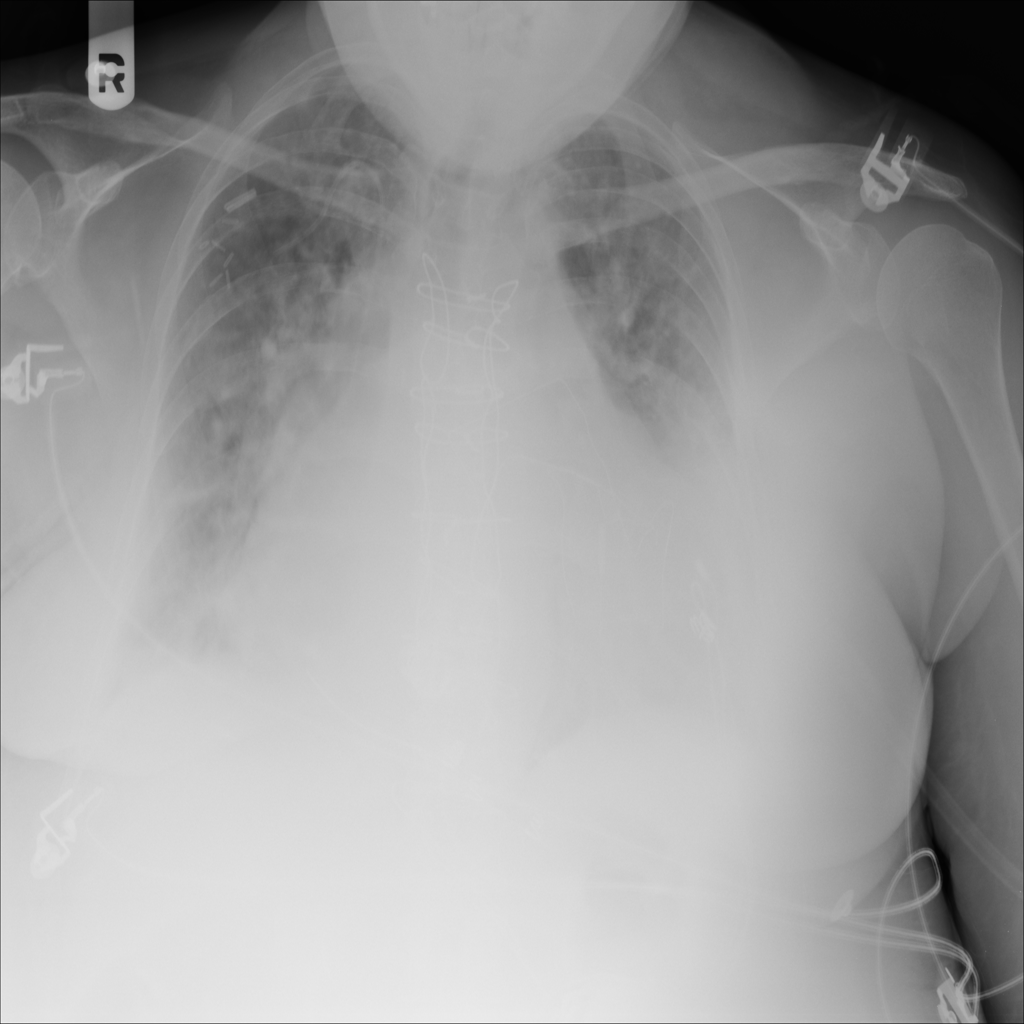

In [18]:
# Preview Page 4: Imaging (for Family)
print("Preview: Page 4 - Imaging (for Family)")
display(HTML(imaging_file.read_text()))

In [19]:
# Preview Page 5: Connections (for Both)
print("Preview: Page 5 - Connections (for Both)")
display(HTML(connections_file.read_text()))

Preview: Page 5 - Connections (for Both)


### 1.7 Multilingual Support: Bengali Fridge Sheet

For Ayahs who cannot read English, CareMap can translate the fridge sheet using Meta's NLLB-200 model:

In [20]:
from caremap.translation import NLLBTranslator

print("Loading NLLB-200 translator...")
translator = NLLBTranslator()
print("Translator ready!")

# Example: Translate medication instructions to Bengali
sample_text = "This medicine helps control your heart rate. Take it every day at the same time. Do NOT stop taking it suddenly."

print(f"\nOriginal (English):")
print(f"  {sample_text}")

bengali = translator.translate_to(sample_text, "ben_Beng")
print(f"\nBengali (for Ayah):")
print(f"  {bengali}")

Loading NLLB-200 translator...
Translator ready!

Original (English):
  This medicine helps control your heart rate. Take it every day at the same time. Do NOT stop taking it suddenly.

Bengali (for Ayah):
  এই ওষুধটি আপনার হৃদস্পন্দন নিয়ন্ত্রণ করতে সাহায্য করে। এটি প্রতিদিন একই সময়ে নিন। এটি গ্রহণ করা হঠাৎ বন্ধ করবেন না।


### 1.8 Bengali Fridge Sheets: Full Page Translation

Now we translate the **complete fridge sheet HTML pages** to Bengali using NLLB-200. This demonstrates the real-world value: an Ayah receives the **same professionally formatted fridge sheet**, but with all instructions in her language.

**What gets translated:**
- Page headings and labels
- MedGemma-generated explanations (why it matters, watch for)
- Action items and next steps
- Time bucket labels (Today, This Week, Later)

**What stays in English (safety-critical):**
- Medication names (Metformin, Warfarin, etc.)
- Dosage amounts (500mg, etc.)
- MedGemma badge

In [21]:
from caremap.html_translator import translate_fridge_sheet_html
import threading, time

print("Translating Medication Schedule to Bengali (\u09ac\u09be\u0982\u09b2\u09be)...")
print("=" * 60)

translate_result = {}
translate_error = [None]

def run_med_translation():
    try:
        translate_result['html'] = translate_fridge_sheet_html(
            html_content=meds_html,
            translator=translator,
            target_lang="ben_Beng",
            progress_callback=lambda c, t, m: print(f"  [{c}/{t}] {m}")
        )
    except Exception as e:
        translate_error[0] = e

thread = threading.Thread(target=run_med_translation)
thread.start()

with tqdm(desc="Medication translation (NLLB-200)", unit="s",
          bar_format="{desc}: {elapsed} elapsed |{bar}|") as pbar:
    while thread.is_alive():
        time.sleep(1)
        pbar.update(1)

thread.join()
if translate_error[0]:
    raise translate_error[0]

bengali_meds_html = translate_result['html']

bengali_med_file = html_output_dir / '1_medications_bn.html'
with open(bengali_med_file, 'w', encoding='utf-8') as f:
    f.write(bengali_meds_html)

print(f"\nSaved: {bengali_med_file.name}")
print("\nPreview: Bengali Medication Schedule (for Ayah)")
display(HTML(bengali_meds_html))

Translating Medication Schedule to Bengali (বাংলা)...
  [1/55] Translating (1/55)


Medication translation (NLLB-200): 00:01 elapsed |          |

  [6/55] Translating (6/55)
  [11/55] Translating (11/55)


Medication translation (NLLB-200): 00:02 elapsed |          |

  [16/55] Translating (16/55)
  [21/55] Translating (21/55)


Medication translation (NLLB-200): 00:05 elapsed |          |

  [26/55] Translating (26/55)


Medication translation (NLLB-200): 00:07 elapsed |          |

  [31/55] Translating (31/55)


Medication translation (NLLB-200): 00:09 elapsed |          |

  [36/55] Translating (36/55)


Medication translation (NLLB-200): 00:11 elapsed |          |

  [41/55] Translating (41/55)


Medication translation (NLLB-200): 00:13 elapsed |          |

  [46/55] Translating (46/55)


Medication translation (NLLB-200): 00:16 elapsed |          |

  [51/55] Translating (51/55)


Medication translation (NLLB-200): 00:18 elapsed |          |

  [55/55] Translating (55/55)


Medication translation (NLLB-200): 00:19 elapsed |          |


Saved: 1_medications_bn.html

Preview: Bengali Medication Schedule (for Ayah)


✓,ঔষধ,কখন,কীভাবে দান করা যায়,কেন তা গুরুত্বপূর্ণ AI,সতর্ক থাকুন
,Metformin 500mg,☀️ সকাল🌅 সন্ধ্যায়,️ খাদ্যের সাথে,এই ওষুধ রক্তে শর্করা হ্রাস করতে সাহায্য করে।,"️ যদি কোনও পরীক্ষায় আপনার কিডনি ভালভাবে কাজ না করে দেখায়, তাহলে এই ওষুধটি গ্রহণ করা বন্ধ করুন। এছাড়াও, কোনও কন্ট্রাস্ট রঙের সিটি স্ক্যানের ৪৮ ঘন্টা আগে এবং পরে এটি গ্রহণ করা বন্ধ করুন। আপনার যদি কোন প্রশ্ন থাকে তবে আপনার ডাক্তারের সাথে কথা বলুন।"
,Warfarin,🌅 সন্ধ্যায়,️ ঐচ্ছিক,এই ওষুধ বিপজ্জনক রক্ত জমাট বাঁধতে সাহায্য করে। এটিকে প্রায়শই 'রক্ত পাতলা' বলা হয় কারণ এটি রক্ত জমাট বাঁধতে বেশি সময় নেয়।,️ ইবুপ্রফেন বা অ্যাস্পিরিনের মতো এনএসআইডি গ্রহণ করবেন না। ডায়েটে প্রতি সপ্তাহে একই পরিমাণ পাতলা সবুজ শাকসব্জী (যেমন স্পিনাক বা কলা) রাখার চেষ্টা করুন। আপনার কোনও অস্বাভাবিক রক্তপাত বা জঘন্যতা থাকলে আপনার ডাক্তারকে জানান।
,Furosemide 40mg,☀️ সকাল🌤️ বিকেলে,️ ঐচ্ছিক,এই ওষুধটি আপনার শরীরকে অতিরিক্ত তরল থেকে মুক্তি দিতে সাহায্য করে। এটি প্রায়শই হৃদরোগ ও প্রদাহের চিকিৎসার জন্য ব্যবহৃত হয়।,"️ প্রতিদিন নিজেকে ওজন করুন। যদি আপনার মাথা ঘোরে বা মাথা ব্যাথা হয় তবে আপনার ডাক্তারকে বলুন। এই ওষুধটি কখনও কখনও আপনার পটাসিয়ামের মাত্রা হ্রাস করতে পারে, তাই আপনার ডাক্তার নির্ধারিত পটাসিয়াম সম্পূরক গ্রহণ করুন।"
,Potassium Chloride,☀️ সকাল,️ খাদ্যের সাথে,পটাসিয়াম একটি গুরুত্বপূর্ণ খনিজ পদার্থ যা আপনার পেশী ও স্নায়ুর সঠিকভাবে কাজ করতে সাহায্য করে।,"️ ট্যাবলেটগুলো নষ্ট করবেন না। পেটের ব্যাথা এড়াতে খাবার সঙ্গে নিন। যদি আপনি অন্য ওষুধ খাচ্ছেন, তাহলে এই ওষুধ গ্রহণ করার আগে আপনার ডাক্তার বা ফার্মাসিস্টের সঙ্গে কথা বলুন।"
,Carvedilol 5mg,☀️ সকাল🌅 সন্ধ্যায়,️ খাদ্যের সাথে,এই ওষুধটি আপনার হৃদপিন্ডকে আরও ভালভাবে কাজ করতে সাহায্য করে এবং আপনার হার্ট রেট হ্রাস করে। এটি হৃদরোগের জন্য এবং আপনার হার্ট রেট নিয়ন্ত্রণ করতে ব্যবহৃত হয়।,"️ এই ওষুধটি আপনাকে মাথা ঘুরিয়ে দিতে পারে, বিশেষ করে যদি আপনি দ্রুত উঠে দাঁড়ান। সবসময় বসে বা শুয়ে থেকে ধীরে ধীরে উঠে দাঁড়ান। এই ওষুধটি হঠাৎ করে নেওয়া বন্ধ করবেন না, কারণ এটি আপনার হৃদয়ের জন্য বিপজ্জনক হতে পারে।"
,Lisinopril 10mg,☀️ সকাল,️ ঐচ্ছিক,"এই ওষুধটি আপনার হৃদয় এবং কিডনিকে রক্ষা করতে সাহায্য করে। এটি রক্তনালীগুলিকে শিথিল করে, যা আপনার হৃদয়ের জন্য রক্ত পাম্প করা সহজ করে তোলে।",️ এই ওষুধটি কখনও কখনও শুকনো কাশি হতে পারে। এটি আপনার রক্তে পটাসিয়ামের মাত্রাও বাড়িয়ে তুলতে পারে। আপনার ডাক্তার রক্ত পরীক্ষার মাধ্যমে আপনার পটাসিয়ামের মাত্রা পরীক্ষা করবেন।
,Levothyroxine 75mcg,☀️ সকাল,️ খালি পেট,এই ওষুধটি আপনার থাইরয়েড গ্রন্থিকে সঠিক পরিমাণে থাইরয়েড হরমোন তৈরি করতে সহায়তা করে।,"️ এই ওষুধটি ক্যালসিয়াম, লোহা বা অ্যান্টিএসিড ওষুধের থেকে কমপক্ষে ৪ ঘন্টা দূরে নিন। এর কারণ এই ওষুধগুলি সঠিকভাবে কাজ করতে বাধা দিতে পারে। যদি আপনি অন্য ওষুধের সাথে এটি গ্রহণ করা উচিত কিনা তা নিশ্চিত না হন তবে আপনার ডাক্তার বা ফার্মাসিস্টকে জিজ্ঞাসা করুন।"
,Acetaminophen 650mg,প্রয়োজনে,️ ঐচ্ছিক,এই ওষুধ ব্যথা দূর করতে এবং জ্বর কমাতে সাহায্য করে।,"️ দিনে ৩০০০ মিলিগ্রাম এসিটামিনোফেন গ্রহণ করবেন না। ইবুপ্রোফেন, ন্যাপ্রক্সেন বা অ্যাস্পিরিনের সাথে এই ওষুধ গ্রহণ করা নিরাপদ নয়। এসিটামিনোফেনের সাথে এই ওষুধগুলি গ্রহণ করা বিপজ্জনক হতে পারে।"


In [22]:
print("Translating Care Actions to Bengali (\u09ac\u09be\u0982\u09b2\u09be)...")
print("=" * 60)

translate_result = {}
translate_error = [None]

def run_gaps_translation():
    try:
        translate_result['html'] = translate_fridge_sheet_html(
            html_content=gaps_html,
            translator=translator,
            target_lang="ben_Beng",
            progress_callback=lambda c, t, m: print(f"  [{c}/{t}] {m}")
        )
    except Exception as e:
        translate_error[0] = e

thread = threading.Thread(target=run_gaps_translation)
thread.start()

with tqdm(desc="Care gaps translation (NLLB-200)", unit="s",
          bar_format="{desc}: {elapsed} elapsed |{bar}|") as pbar:
    while thread.is_alive():
        time.sleep(1)
        pbar.update(1)

thread.join()
if translate_error[0]:
    raise translate_error[0]

bengali_gaps_html = translate_result['html']

bengali_gaps_file = html_output_dir / '3_care_gaps_bn.html'
with open(bengali_gaps_file, 'w', encoding='utf-8') as f:
    f.write(bengali_gaps_html)

print(f"\nSaved: {bengali_gaps_file.name}")
print("\nPreview: Bengali Care Actions (for Family)")
display(HTML(bengali_gaps_html))

Translating Care Actions to Bengali (বাংলা)...
  [1/31] Translating (1/31)


Care gaps translation (NLLB-200): 00:01 elapsed |          |

  [6/31] Translating (6/31)


Care gaps translation (NLLB-200): 00:02 elapsed |          |

  [11/31] Translating (11/31)


Care gaps translation (NLLB-200): 00:03 elapsed |          |

  [16/31] Translating (16/31)
  [21/31] Translating (21/31)


Care gaps translation (NLLB-200): 00:04 elapsed |          |

  [26/31] Translating (26/31)


Care gaps translation (NLLB-200): 00:05 elapsed |          |

  [31/31] Translating (31/31)


Care gaps translation (NLLB-200): 00:06 elapsed |          |


Saved: 3_care_gaps_bn.html

Preview: Bengali Care Actions (for Family)


---

## Module 2: Radiology Triage (Multimodal)

### The Problem

| Metric | India | Impact |
|--------|-------|--------|
| Radiologist-to-patient ratio | 1:100,000 | Severe shortage |
| Average X-ray report delay | 72 hours | Critical findings missed |
| Daily imaging volume | 500+ studies/radiologist | Burnout, errors |

### The Solution: MedGemma Multimodal Triage

MedGemma analyzes chest X-rays and assigns priority:

| Priority | Review Time | Examples |
|----------|-------------|----------|
| STAT | < 1 hour | Pulmonary edema, pneumothorax |
| SOON | < 24 hours | Cardiomegaly, consolidation |
| ROUTINE | 48-72 hours | Normal, minor findings |

**Key Principle:** AI prioritizes the worklist. Radiologists review ALL images.

In [23]:
# Load MedGemma with multimodal support
print("Loading MedGemma with multimodal support...")
multimodal_client = MedGemmaClient(enable_multimodal=True)
print(f"Device: {multimodal_client.device}")
print("Ready for image analysis!")

Loading MedGemma with multimodal support...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


Device: mps
Ready for image analysis!


STAT Case: 00000032_001.png
Patient: 55 year old F
Ground Truth: Cardiomegaly|Edema|Effusion


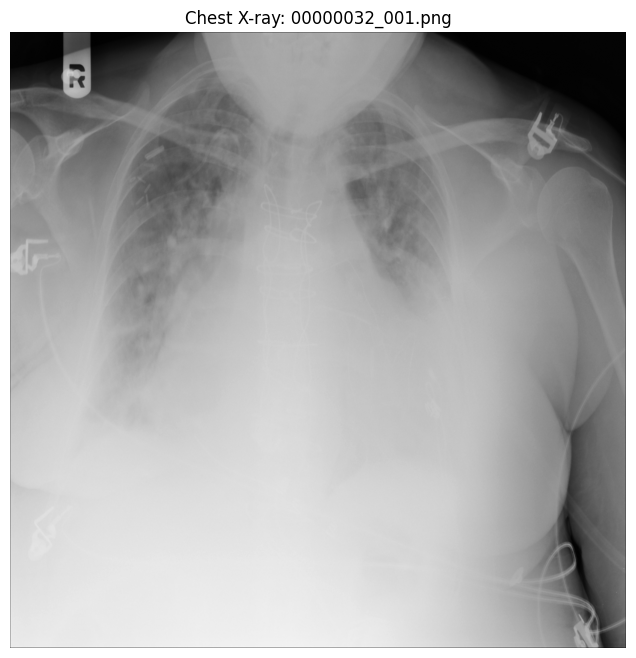

In [24]:
# Load sample X-ray from NIH dataset
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

demo_images_dir = project_root / 'data' / 'nih_chest_xray' / 'demo_images'
manifest_path = project_root / 'data' / 'nih_chest_xray' / 'sample_manifest.csv'
manifest = pd.read_csv(manifest_path)

# Display a STAT case
stat_image = manifest[manifest['priority'] == 'STAT'].iloc[0]
image_path = demo_images_dir / 'stat' / stat_image['image_id']

print(f"STAT Case: {stat_image['image_id']}")
print(f"Patient: {stat_image['patient_age']} year old {stat_image['patient_gender']}")
print(f"Ground Truth: {stat_image['findings']}")

img = Image.open(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.title(f"Chest X-ray: {stat_image['image_id']}")
plt.axis('off')
plt.show()

In [25]:
import threading
import time
from caremap.radiology_triage import analyze_xray

print("Analyzing X-ray with MedGemma multimodal...")
print("(Single LLM call - typically takes 1-2 minutes on MPS)")

xray_result = {}
xray_error = [None]

def run_xray_analysis():
    try:
        xray_result.update(analyze_xray(
            client=multimodal_client,
            image_path=str(image_path),
            patient_age=int(stat_image['patient_age']),
            patient_gender=stat_image['patient_gender']
        ))
    except Exception as e:
        xray_error[0] = e

thread = threading.Thread(target=run_xray_analysis)
thread.start()

with tqdm(desc="X-ray Triage (MedGemma inference)", unit="s", bar_format="{desc}: {elapsed} elapsed |{bar}|") as pbar:
    while thread.is_alive():
        time.sleep(1)
        pbar.update(1)

thread.join()
if xray_error[0]:
    raise xray_error[0]

result = xray_result
priority_emoji = {'STAT': '\U0001F534', 'SOON': '\U0001F7E1', 'ROUTINE': '\U0001F7E2'}
priority = result.get('priority', 'STAT')

print(f"\n{priority_emoji.get(priority, '')} MedGemma Triage Result: {priority}")
print(f"Confidence: {result.get('confidence', 0):.0%}")
print(f"\nFindings:")
for finding in result.get('findings', []):
    print(f"  - {finding}")
print(f"\nGround Truth: {stat_image['findings']}")

Analyzing X-ray with MedGemma multimodal...
(Single LLM call - typically takes 1-2 minutes on MPS)


X-ray Triage (MedGemma inference): 00:17 elapsed |          |


🟡 MedGemma Triage Result: SOON
Confidence: 80%

Findings:
  - Cardiomegaly
  - Pulmonary edema
  - Pleural effusion

Ground Truth: Cardiomegaly|Edema|Effusion


---

## Module 3: HL7 ORU Message Triage (Text)

### The Problem

Clinical staff receive **1000+ HL7 messages per day**. Critical values (K+ > 6.5, Troponin elevation) can be buried in routine results.

### The Solution: MedGemma Text Reasoning

MedGemma triages incoming lab results and clinical messages by urgency.

In [26]:
from caremap.hl7_triage import load_sample_messages, triage_oru_message

messages = load_sample_messages()
stat_msg = [m for m in messages if m['expected_priority'] == 'STAT'][0]

print(f"Sample STAT Message: {stat_msg['message_id']}")
print(f"Patient: {stat_msg['patient']['age']}yo {stat_msg['patient']['gender']}")
print(f"Context: {stat_msg['clinical_context']}")
print(f"\nObservations:")
for obs in stat_msg['observations']:
    print(f"  - {obs['test_name']}: {obs['value']} {obs.get('units', '')} (ref: {obs['reference_range']})")

Sample STAT Message: ORU-001
Patient: 67yo M
Context: Patient on ACE inhibitor and potassium-sparing diuretic

Observations:
  - Potassium: 6.8 mEq/L (ref: 3.5-5.0)


In [27]:
import threading
import time

print("\nTriaging with MedGemma...")
print("(Single LLM call - typically takes 1-2 minutes on MPS)")

triage_result = {}
triage_error = [None]

def run_triage():
    try:
        triage_result.update(triage_oru_message(client, stat_msg))
    except Exception as e:
        triage_error[0] = e

thread = threading.Thread(target=run_triage)
thread.start()

with tqdm(desc="HL7 Triage (MedGemma inference)", unit="s", bar_format="{desc}: {elapsed} elapsed |{bar}|") as pbar:
    while thread.is_alive():
        time.sleep(1)
        pbar.update(1)

thread.join()
if triage_error[0]:
    raise triage_error[0]

result = triage_result
priority = result.get('priority', 'STAT')
print(f"\n{priority_emoji.get(priority, '')} Triage Result: {priority}")
print(f"Reason: {result.get('priority_reason', 'N/A')}")
print(f"Recommended Action: {result.get('recommended_action', 'N/A')}")


Triaging with MedGemma...
(Single LLM call - typically takes 1-2 minutes on MPS)


HL7 Triage (MedGemma inference): 02:11 elapsed |          |


🔴 Triage Result: STAT
Reason: Potassium level of 6.8 mEq/L is significantly elevated and requires immediate attention, especially given the patient's use of an ACE inhibitor and potassium-sparing diuretic, which can exacerbate hyperkalemia.
Recommended Action: Immediately assess the patient for signs and symptoms of hyperkalemia (e.g., muscle weakness, cardiac arrhythmias). Consider interventions to lower potassium levels, such as calcium gluconate, insulin with glucose, sodium bicarbonate, or dialysis.


---

## Impact Summary

### One Model, Maximum Impact

| Module | Beneficiary | Impact |
|--------|-------------|--------|
| **Fridge Sheets** | Caregivers & Ayahs | Reduced confusion, fewer medication errors |
| **Radiology Triage** | Radiologists | Critical findings prioritized, faster diagnosis |
| **HL7 Triage** | Lab/Clinical Staff | Life-threatening values surfaced immediately |

### Why This Matters for India

- **Caregivers**: Rotating Ayahs can follow clear instructions without verbal handoffs
- **Radiologists**: Scarce specialists can focus on urgent cases first
- **Patients**: Better outcomes through timely intervention

### The Poster Effect: From Recall to Reference

> "The ayah changes every week. **How do you hand off care?**" — Dr. Gaurav Mishra

Printed fridge sheets fundamentally change how care is communicated:

| Without CareMap | With CareMap |
|-----------------|--------------|
| Outgoing ayah tries to remember all instructions | Outgoing ayah points to the poster on the fridge |
| New ayah relies on verbal handoff (incomplete, error-prone) | New ayah reads the poster and asks clarifying questions |
| Family must re-explain everything each week | Family walks new ayah through the printed pages once |
| Critical warnings get forgotten over time | Warnings stay visible: "Do NOT take with ibuprofen" |

**The goal is not perfect recall — it's reliable reference.** When the poster is on the fridge, the next Ayah doesn't need to memorize anything. They just need to read, follow, and ask when something doesn't make sense.

---

## Model Attribution

```bibtex
@article{sellergren2025medgemma,
  title={MedGemma Technical Report},
  author={Sellergren, Andrew and others},
  journal={arXiv preprint arXiv:2507.05201},
  year={2025}
}
```

---

**Interactive Demo:** [CareMap on HuggingFace Spaces](https://huggingface.co/spaces/codekunoichi/caremap-medgemma)

*CareMap - Making healthcare information accessible and actionable.*